### LAYOUTLM Model Fine-tuning
*Intuitions on developing a fine-tuned model for Form understanding on the FUNSD dataset and Form 16*

In [2]:
import numpy as np
import pandas as pd
from transformers import LayoutLMForTokenClassification, LayoutLMTokenizer, LayoutLMConfig
from PIL import Image, ImageDraw, ImageFont
import torch
from torch import nn

In [3]:
# ! curl https://guillaumejaume.github.io/FUNSD/dataset.zip
# ! unzip dataset.zip && mv dataset data

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
config = LayoutLMConfig(max_position_embeddings=768, num_labels=13)
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=13)
                                                       # config=config, ignore_mismatched_sizes=True)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
model

In [4]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)

[PAD] 0
[SEP] 102
[CLS] 101


In [5]:
# drawing utility
image_path = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\Form_16_jpeg\finance_doc_1.jpg"
annotation = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\annotations\ocr_anno_finance_doc_1.jpg.csv"
ann_df = pd.read_csv(annotation)
box_cols = ["left", "top", "width", "height"]

coords = ann_df[box_cols]
ann_boxes = []
for idx, row in coords.iterrows():
    x, y, w, h = tuple(row)
    ann_boxes.append([x, y, x + w, y + h])

img = Image.open(image_path).convert("RGB")

In [6]:

def draw_boxes(img, boxes, labels):
    drawer = ImageDraw.Draw(img, "RGBA")
    font = ImageFont.load_default()

    if labels is not None:
        for box, label in zip(boxes, labels):
            drawer.rectangle(box, width=2, outline="red")
            drawer.text((box[0] + 10, box[1] - 10), label_map[label] if not isinstance(label, str) else label, fill=color_map[label_map[label] if not isinstance(label, str) else label], font=font)
    else:
        for box in boxes:
            drawer.rectangle(box, width=2, outline="red")

    return img


img = draw_boxes(img, ann_boxes, None)


In [ ]:

img

In [7]:
import glob
import os
import json

def label_bioes(ann_dir, ann_type="csv"):
    if ann_type in ["csv", "xlsx"]:
        ann_paths = glob.glob(os.path.join(ann_dir, "*.xlsx"))
    elif ann_type=="json":
        ann_paths = glob.glob(os.path.join(ann_dir, "*.json"))

    for path in ann_paths:
        words = []
        labels = []
        if ann_type in ["csv", "xlsx"]:
            ann_df = pd.read_excel(path)
            ann_cols = ["left", "top", "width", "height", "text", "label"]
            ann_fields = ann_df[ann_cols]
            for i, row in ann_fields.iterrows():
                words.append(row["text"].strip() if isinstance(row["text"], str) else str(row["text"]).strip())
                labels.append(row["label"])

            bioes_labels = []
            i = 0
            while i < len(labels):
                label = labels[i]
                # word = words[i]
                sent_len = 1
                word_pointer = i
                while word_pointer + 1 < len(labels) and label == labels[word_pointer + 1]:
                    sent_len += 1
                    word_pointer += 1
                if sent_len == 1:
                    bioes_labels.append("S-" + label.upper() if label != "other" else "O")
                elif sent_len > 1:
                    bioes_labels.append("B-" + labels[i].upper() if label != "other" else "O")
                    while i < word_pointer - 1:
                        bioes_labels.append("I-" + labels[i].upper() if label != "other" else "O")
                        i += 1
                    bioes_labels.append("E-" + labels[i].upper() if label != "other" else "O")
                    i += 1
                i += 1


            ann_df["LABELS"] = bioes_labels
            ann_df.to_csv(path)

        elif ann_type=="json":
            with open(path, encoding="UTF-8") as f:
                ann_data = json.load(f)

            for ann in ann_data["form"]:
                if ann["text"]!= "":
                    if len(ann["words"]) == 1:
                        ann["words"][0]["LABEL"] = "S-" + ann["label"].upper() if ann["label"] != "other" else "O"
                    elif len(ann["words"]) > 1:
                        ann["words"][0]["LABEL"] = "B-" + ann["label"].upper() if ann["label"] != "other" else "O"
                        for word in ann["words"][1:-1]:
                            word["LABEL"] = "I-" + ann["label"].upper() if ann["label"] != "other" else "O"

                        ann["words"][-1]["LABEL"] = "E-" + ann["label"].upper() if ann["label"] != "other" else "O"

            with open(path, "w", encoding="utf-8") as fp:
                json.dump(ann_data, fp, indent=4)


label_bioes(ann_dir=r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\labelled_annotations\labelled")

def get_label_list(ann_dir, ann_type="csv"):
    if ann_type == "csv":
        ann_paths = glob.glob(os.path.join(ann_dir, "*.csv"))
    elif ann_type == "json":
        ann_paths = glob.glob(os.path.join(ann_dir, "*.json"))

    all_labels = []
    if ann_type == "csv":
        for path in ann_paths:
            labels = []
            ann_df = pd.read_csv(path)
            ann_cols = ["left", "top", "width", "height", "text", "label", "LABELS"]
            ann_fields = ann_df[ann_cols]
            for i, row in ann_fields.iterrows():
                labels.append(row["LABELS"])
            all_labels.extend(labels)

    if ann_type =="json":
        for path in ann_paths:
            labels = []
            with open(path, encoding="UTF-8") as f:
                    ann_data = json.load(f)

            for ann in ann_data["form"]:
                if ann["text"]!= "":
                    label = [word["LABEL"].strip() for word in ann["words"] if word["text"] != ""]
                    labels.extend(label)
            all_labels.extend(labels)

    unique_labels = set(all_labels)
    print(unique_labels)

    with open("label_bioes.txt", "w") as fp:
        for label in sorted(list(unique_labels)):
            fp.write(label+"\n")

get_label_list(ann_dir=r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\labelled_annotations\labelled")

{'B-NAME_ADDRESS_EMPLOYEE', 'S-ASSESSMENT_YEAR', 'E-TAX_PAYABLE', 'S-TAN_DEDUCTOR', 'S-PAN_EMPLOYEE', 'E-NAME_ADDRESS_EMPLOYER', 'B-NAME_ADDRESS_EMPLOYER', 'S-PERIOD_WITH_EMPLOYER_FROM', 'O', 'I-NAME_ADDRESS_EMPLOYER', 'I-NAME_ADDRESS_EMPLOYEE', 'E-NAME_ADDRESS_EMPLOYEE', 'S-CERTIFICATE_NO', 'S-PERIOD_WITH_EMPLOYER_TO', 'S-PAN_DEDUCTOR', 'S-TAX_PAYABLE', 'S-QUARTER_RECEIPT', 'S-NET_SALARY', 'S-LAST_UPDATED_ON', 'S-GROSS_SALARY', 'B-TAX_PAYABLE'}


In [8]:
# BIOES format for the FUNSD dataset

# training data
label_bioes(ann_dir=r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\annotations",
            ann_type="json")

# test data
label_bioes(ann_dir=r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\annotations",
            ann_type="json")

get_label_list(ann_dir=r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\annotations",
               ann_type="json")

{'E-ANSWER', 'E-HEADER', 'I-ANSWER', 'B-HEADER', 'B-ANSWER', 'B-QUESTION', 'I-QUESTION', 'S-QUESTION', 'S-HEADER', 'I-HEADER', 'S-ANSWER', 'E-QUESTION', 'O'}


In [15]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
import json

# label_list = ["question", "answer", "header", "other"]  # for FUNSD dataset

with open(r"label_bioes.txt", encoding="UTF-8") as fp:
    label_list = [line.strip() for line in fp.readlines()]


class DocParsingDataset(Dataset):
    def __init__(self, image_path, anno_path, tokenizer, max_length, pad_label_id, ann_type="json", label_format="normal"):
        super(DocParsingDataset, self).__init__()
        self.image_path = image_path
        self.anno_path = anno_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.ann_type = ann_type
        self.pad_label_id = pad_label_id
        self.label_format = label_format
        if self.label_format not in ["normal", "bioes"]:
            raise NotImplementedError("Not Implemented pass in {}".format(["normal", "bioes"]))
        if ann_type not in ["csv", "json", "xlsx"]:
            raise NotImplementedError("Not implemented pass in {}".format(["csv", "json", "xlsx"]))
        self.anno_filenames = sorted(glob.glob(os.path.join(self.anno_path, "*.{}".format(ann_type))))

        self.image_names = sorted(glob.glob(os.path.join(self.image_path, "*.jpg"), ))[:len(self.anno_filenames)]

        if len(self.image_names) == 0:
            self.image_names = sorted(glob.glob(os.path.join(self.image_path, "*.png"), ))[:len(self.anno_filenames)]

    def __len__(self):
        return len(self.anno_filenames)

    @staticmethod
    def normalize(box, img_width, img_height):
        return [int(1000 * box[0] / img_width),
                int(1000 * box[1] / img_height),
                int(1000 * box[2] / img_width),
                int(1000 * box[3] / img_height)]

    def create_data_examples(self, words, labels, boxes, cls_token_box=[0, 0, 0, 0],
                             sep_token_box=[1000, 1000, 1000, 1000],
                             pad_token_box=[0, 0, 0, 0]):
        """take in words boxes and labels return tokenized output with params
        input_ids, attention_mask, labels, and token_type_ids"""
        label_map = {label: i for i, label in enumerate(label_list)}
        pad_token = self.tokenizer.pad_token
        sep_token = self.tokenizer.sep_token
        cls_token = self.tokenizer.cls_token
        tokens = []
        token_boxes = []
        label_ids = []

        for word, label, box in zip(words, labels, boxes):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            label_ids.extend([label_map[label]] + [self.pad_label_id] * (len(word_tokens) - 1))

        special_tokens_count = 2
        if len(tokens) > self.max_length - special_tokens_count:
            tokens = tokens[:(self.max_length - special_tokens_count)]
            token_boxes = token_boxes[:(self.max_length - special_tokens_count)]
            label_ids = label_ids[:(self.max_length - special_tokens_count)]

        tokens += [sep_token]
        token_boxes += [sep_token_box]
        label_ids += [self.pad_label_id]

        tokens = [cls_token] + tokens
        token_boxes = [cls_token_box] + token_boxes
        label_ids = [self.pad_label_id] + label_ids

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        padding_len = self.max_length - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_len
        token_boxes += [pad_token_box] * padding_len
        attention_mask += [0] * padding_len
        label_ids += [self.pad_label_id] * padding_len

        assert len(input_ids) == self.max_length
        assert len(token_boxes) == self.max_length
        assert len(attention_mask) == self.max_length
        assert len(label_ids) == self.max_length

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.zeros(len(input_ids), dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long),
            "bbox": torch.tensor(token_boxes)
        }

    def __getitem__(self, item):
        ann_file = self.anno_filenames[item]
        img_file = self.image_names[item]
        # print(ann_file, img_file)
        if item < 3:
            print(img_file, ann_file)
        img = Image.open(img_file).convert("RGB")
        img_height, img_width, _ = np.asarray(img).shape
        words, boxes, labels = [], [], []
        if self.ann_type == "json":
            with open(ann_file, encoding="UTF-8") as f:
                ann_data = json.load(f)

            for ann in ann_data["form"]:
                if ann["text"]!= "":
                    wrd = [word["text"].strip() for word in ann["words"] if word["text"] != ""]
                    words.extend(wrd)
                    if self.label_format == "normal":
                        labels.extend([ann["label"]] * len(wrd))
                    elif self.label_format == "bioes":
                        labels.extend([word["LABEL"] for word in ann["words"] if word["text"] != ""])
                    boxes.extend([self.normalize(word["box"], img_width, img_height) for word in ann["words"]])

        elif self.ann_type == "csv":
            ann_df = pd.read_csv(ann_file)
            ann_cols = ["left", "top", "width", "height", "text", "label"]
            ann_fields = ann_df[ann_cols]
            for i, row in ann_fields.iterrows():
                words.append(row["text"].strip())
                if self.label_format == "normal":
                    labels.append(row["label"].strip())
                elif self.label_format == "bioes":
                    labels.append(row["LABELS"].strip())
                box = [row["left"], row["top"], row["width"] + row["left"],
                       row["height"] + row["top"]]
                boxes.append(self.normalize(box, img_width, img_height))

        elif self.ann_type == "xlsx":
            ann_df = pd.DataFrame(pd.read_excel(ann_file))

            ann_cols = ["left", "top", "width", "height", "text", "label"]
            ann_fields = ann_df[ann_cols]
            for i, row in ann_fields.iterrows():
                words.append(row["text"].strip() if isinstance(row["text"], str) else str(row["text"]).strip())
                if self.label_format == "normal":
                    labels.append(row["label"].strip() if row["label"].strip()!="nan" else "other")
                elif self.label_format == "bioes":
                    labels.append(row["LABELS"].strip() if row["LABELS"].strip()!="nan" else "other")
                box = [row["left"], row["top"], row["width"] + row["left"],
                       row["height"] + row["top"]]
                boxes.append(self.normalize(box, img_width, img_height))

        else:
            raise NotImplementedError("Use ann_type as ""json"" or ""csv""!")

        annotations = self.create_data_examples(words, labels, boxes)

        return annotations


In [10]:
# FORM 16 dataset
labelled_path = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\labelled_annotations\labelled"

csv_dataset = DocParsingDataset(
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\labelled_Form_16",
    labelled_path,
    tokenizer,
    768,
    -100,
    "xlsx")


for tokens in tokenizer.convert_ids_to_tokens(csv_dataset[0]["input_ids"]):
    print(tokens, end=" ")

csv_dataloader = DataLoader(csv_dataset, batch_size=2, shuffle=True)

# for batch in csv_dataloader:
#     print(batch)

[CLS] y ##p td ##s centralized processing cell traces td ##s reconciliation analysis and correction enabling system government of india income tax department form no . 16 [ see rule 31 ( 1 ) ( a ) ] part ##a certificate under section 203 of the income - tax act , 1961 for tax de ##ducted at source on salary certificate no . r ##x ##z ##sc ##v ##l last updated on 2018 - 05 - 28 00 : 00 : 00 name and address of the employer name and address of the employee honey ##well technology solutions lab pv ##t ltd no . 151 / 1 , banner ##gh ##att ##a road , dora ##isan ##ip ##aly ##a , bangalore - 560 ##0 ##7 ##6 karnataka + ( 91 ) 80 - 265 ##8 ##8 ##36 ##0 payroll ##apa ##c @ honey ##well . com sure ##sh dev ##endra ##ppa naga ##vi 305 , da ##ff ##od ##il esteem park , 202 ##2 - 03 - 06 00 : 00 : 00 rose garden road , j p nagar vt ##h phase , bangalore - 560 ##0 ##7 ##8 karnataka pan of the employee employee reference no . pan of the de ##du ##ctor tan of the de ##du ##ctor provided by the employ

In [10]:
dataset = DocParsingDataset(
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\images",
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\training_data\annotations",
    tokenizer,
    512,
    -100,
    label_format="bioes"
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

example = tokenizer.convert_ids_to_tokens(dataset[0]["input_ids"].cpu().numpy().tolist())
print(dataset[0]["labels"])
for ex in example:
    print(ex, end=" ")

tensor([-100,    9, -100, -100,   12,   12, -100,   12, -100,   10, -100,   12,
          12,    9, -100, -100, -100, -100, -100,    1, -100, -100,    7,    7,
           7, -100,    7,    4,    2,    8,    8,    8, -100, -100,    5,    0,
        -100,    6, -100,    6, -100,    6, -100,    6, -100,    3,    0, -100,
           6, -100,    3,    2, -100, -100,    5, -100,    0, -100,    6, -100,
           3, -100,    2,    8,    5,    0, -100, -100, -100,    6,    6,    6,
           6,    6, -100,    6,    6,    6,    6, -100,    6,    6,    6,    6,
           6,    6,    6,    6,    6,    6, -100, -100,    6,    6, -100, -100,
           6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
        -100, -100,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
           6, -100,    6,    6,    6,    6,    6,    6,    6,    6,    3,    2,
           8,    8, -100, -100,    5,    0, -100,    6,    6,    6,    6,    6,
           6,    6,    6,    6,    6,   

In [18]:

for batch in dataloader:
    outputs = model(**batch)
    print(outputs.loss, outputs.logits.shape)
    break


tensor(2.6756, grad_fn=<NllLossBackward0>) torch.Size([2, 512, 13])


In [21]:
len(dataloader)

75

In [19]:
# train
from torch.optim import AdamW
from tqdm import tqdm

num_epochs = 5

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
losses = []
for epoch in range(num_epochs):
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training Epoch {}".format(epoch + 1)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print("Loss after EPOCH {}: {:.2}".format(epoch + 1, sum(losses) / len(losses)))


Training Epoch 1: 100%|██████████| 75/75 [07:18<00:00,  5.84s/it]


Loss after EPOCH 1: 1.8


Training Epoch 2: 100%|██████████| 75/75 [07:15<00:00,  5.80s/it]


Loss after EPOCH 2: 1.4


Training Epoch 3: 100%|██████████| 75/75 [07:14<00:00,  5.79s/it]


Loss after EPOCH 3: 1.1


Training Epoch 4: 100%|██████████| 75/75 [07:26<00:00,  5.95s/it]


Loss after EPOCH 4: 0.95


Training Epoch 5: 100%|██████████| 75/75 [09:13<00:00,  7.38s/it]

Loss after EPOCH 5: 0.81


In [16]:
# eval dataset and loader FUNSD dataset
eval_dataset = DocParsingDataset(
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\images",
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\annotations",
    tokenizer,
    512,
    -100,
    label_format="bioes")

eval_dataloader = DataLoader(eval_dataset, batch_size=2, shuffle=True)

In [24]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

label_map = {i: label for i, label in enumerate(label_list)}

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        # forward pass
        outputs = model(**batch)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != -100:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 25/25 [00:50<00:00,  2.04s/it]

{'loss': 0.929659475684166, 'precision': 0.6180672268907563, 'recall': 0.7380832915203211, 'f1': 0.6727646924308255}


In [25]:
model.save_pretrained(r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\models\funsd-bioes-uncased-5")


In [12]:

def postprocess(boxes, true_labels, predicted_labels, token_ids, original_label_list):
    mapper = {i: label for i, label in enumerate(original_label_list)}
    word_level_predictions = []
    final_boxes = []
    word_level_labels = []
    for id, pred_label, box, token_label in zip(token_ids, predicted_labels, boxes, true_labels):
        if (tokenizer.decode(id).startswith("##")) or (id in [tokenizer.cls_token_id,
                                                              tokenizer.pad_token_id,
                                                              tokenizer.sep_token_id]):
            continue

        else:
            word_level_predictions.append(pred_label)
            final_boxes.append(box)
            word_level_labels.append(token_label)

    # remove bioes labels
    un_bioesed_preds = []
    un_bioesed_labels = []
    for label_id, pred_id in zip(word_level_labels, word_level_predictions):
        pred = mapper[pred_id]
        un_bioesed_preds.append(pred[2:].lower() if pred != "O" else "other")
        if label_id != -100:
            label = mapper[label_id]
            un_bioesed_labels.append(label[2:].lower() if label != "O" else "other")


    return un_bioesed_labels, un_bioesed_preds, final_boxes


def denormalize(bbox, height, width):
    return [
        int(bbox[0] * width / 1000),
        int(bbox[1] * height / 1000),
        int(bbox[2] * width / 1000),
        int(bbox[3] * height / 1000),

    ]

In [22]:
# test viz
pre_model = LayoutLMForTokenClassification.from_pretrained(
    r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\models\funsd-bioes-uncased-5")

example = next(iter(eval_dataloader))
true_labels = example.pop("labels")

pre_model.eval()
outputs = pre_model(**example)
print(outputs.logits[0].argmax(-1).detach().cpu().tolist())
print(tokenizer.convert_ids_to_tokens(example["input_ids"][0]))
# print(true_labels[0])

[8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 9, 9, 9, 9, 9, 9, 9, 1, 7, 4, 2, 8, 5, 12, 2, 5, 12, 0, 3, 3, 3, 3, 0, 3, 6, 3, 2, 8, 5, 5, 2, 8, 5, 5, 12, 5, 2, 5, 5, 2, 5, 5, 2, 5, 5, 2, 8, 8, 5, 5, 2, 8, 8, 4, 5, 2, 8, 8, 8, 8, 5, 5, 2, 8, 7, 8, 5, 5, 2, 8, 8, 8, 5, 5, 2, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 5, 2, 8, 8, 8, 8, 8, 8, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 8, 8, 9, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 7, 8, 4, 9, 2, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 5, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 2, 8, 5, 2, 5, 2, 5, 2, 8, 8, 5, 2, 5, 2, 5, 2, 8, 8, 5, 2, 8, 5, 2, 5, 2, 5, 2, 5, 2, 8, 8, 8, 8, 5, 5, 2, 2, 5, 2, 8, 8, 5, 8, 2, 2, 2, 2, 2, 5, 5, 9, 9, 9, 9, 9, 5, 4, 4, 4, 4, 5, 5, 4, 9, 2, 2, 2, 8, 8, 2, 8, 9, 9, 9, 4, 4, 8,

In [19]:
# post-processing and drawing the predictions
true_word_labels, word_predictions, word_boxes = postprocess(
    example["bbox"][0].detach().cpu().tolist(),
    true_labels[0].detach().cpu().tolist(),
    outputs.logits[0].argmax(-1).detach().cpu().tolist(),
    example["input_ids"][0].detach().cpu().tolist(),
    label_list
)

color_map = {'question': 'blue', 'answer': 'green', 'header': 'orange', 'other': 'violet', "": 'violet'}
label_map = {i: label for i, label in enumerate(label_list)}
label_map[-100] = ''

test_img_path = r"C:\Users\parth.shastri.AD1\PycharmProjects\DocExtraction\data\FUNSD_dataset\testing_data\images\82092117.png"
test_img = Image.open(test_img_path).convert("RGB")

test_img_height, test_img_width, _ = np.asarray(test_img).shape

unnorm_bbox = [denormalize(bbox, test_img_height, test_img_width) for bbox in word_boxes]

test_img = draw_boxes(test_img, unnorm_bbox, word_predictions)

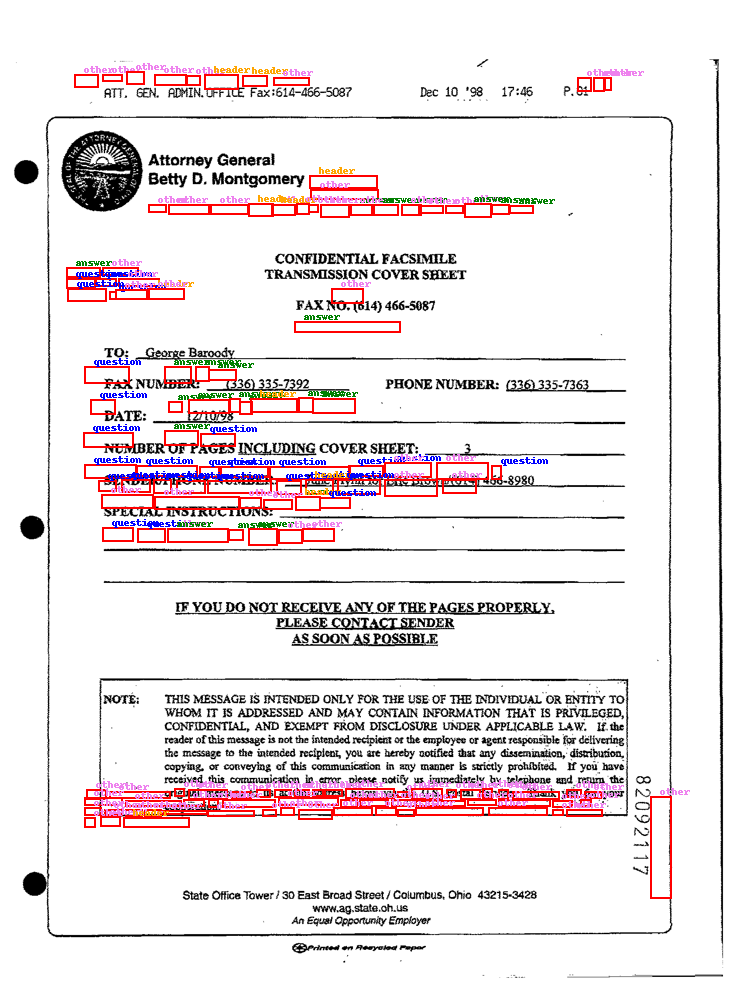

In [25]:
# visualize the predicted labels
test_img

In [23]:
orig_img = Image.open(test_img_path).convert("RGB")
orig_img = draw_boxes(orig_img, unnorm_bbox, true_word_labels)

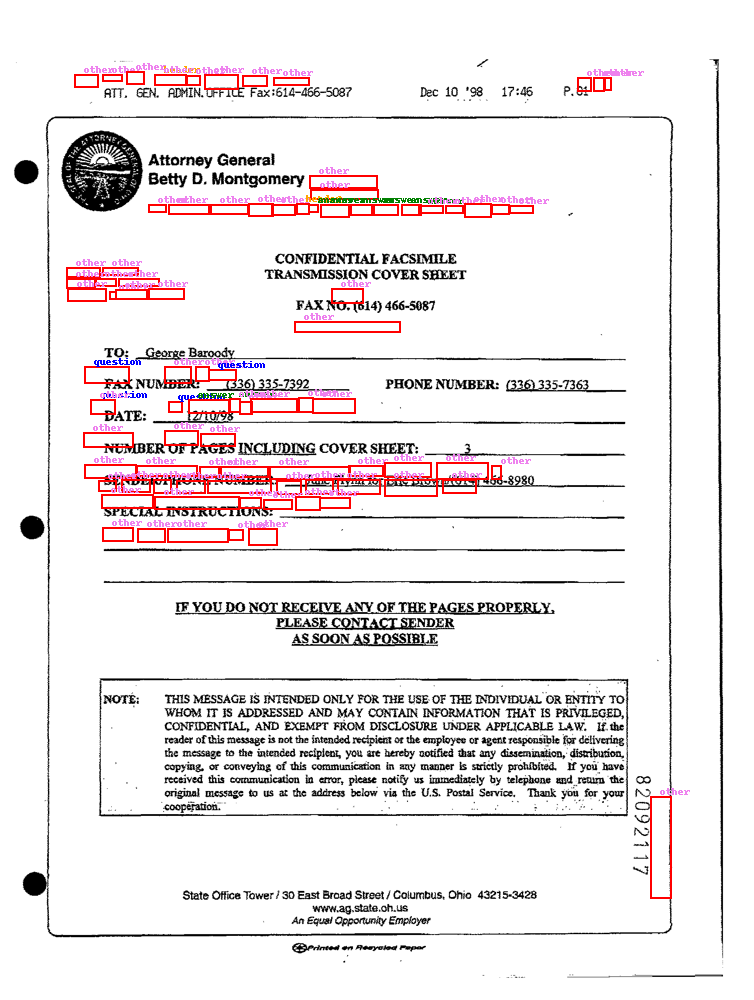

In [24]:
# visualize the original labels
orig_img

In [53]:
print(outputs.logits[0].argmax(-1).detach().cpu().tolist())
print(tokenizer.convert_ids_to_tokens(example["input_ids"][0]))

[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 